# micaImages_abundanceStats
The main purpose of this workbook is to have a better understanding of the statistics of the abundances generated by Yuki's model. In particular I will be focussing on statistics that are:<br>
<ul>
<li> <b>Pixel Level Statistics</b> -- These statistics attempt to give us some information on the statistics for a given pixel such as:<br>
    <ol>
    <li> <i>Number of non-zero endmembers</i>: The number of endmembers with non-zero coefficients in a given image.<br>
    <li> <i>Number of significant endmembers</i>: An end-member is considered significant if the weight associated with the endmember is greater than a specific % of the total weight.<br>    
    </ol>
<li> <b> End-Member Level Stats</b> -- The statistics attempt to provide some insight on how often a specific endmember is used across the MICA image dataset.
    <ol> 
    <li> <i> Frequency</i> -- How often a specific endmember is chosen in the reconstruction.
    <li> <i> Main component</i> -- This statistic counts how often the specific endmember is one of top 3 highest contributors.
    <li> <i> Endmember Mean</i> -- This is the average co-efficient for that endmember (from the non-zero values) 
    <li> <i> Endmember Std. Dev.</i> -- This is the standard deviation of the endmember from the non-zero co-efficients.
    <li> <i> Significant Endmember Mean</i> -- This the average coefficent assigned to the endmember when it is a significant contibutor to the sample. </li>
    <li> <i> Significant Endmember Std. Dev.</i> -- This the standard deviation of the endmember when it is a significant contibutor to the sample. </li>
    </ol>
</ul>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from numpy.matlib import repmat

import warnings
warnings.filterwarnings('ignore')

from crismAbundanceStatistics import crismAbundanceStats

In [7]:
'The base folder where the MICA images are present are'
baseFolder = '/Volume1/data/CRISM/arun/sabcondv3/micaImages/'

'Create an object of the crismAbundanceStats'
ob1 = crismAbundanceStats(baseFolder)

'The folder which contain the images we want to analyze'
dirList = next(os.walk(baseFolder))[1]

'Thereshold beyond which a endmembers contibution is considered significant'
thresh = 0.075

# Pixel level Statistics
In these statistics we are going to look into the statistics of each pixel. In particular the number of endmembers which are involved in creating the general samples. We wiil refer to this as <i>count of non-zero endmembers</i>. Additionally, we will also define end-members whose contibution is greater than 10% as <i>significant endmembers</i> and we will also count the number of significant end-members as the <i>count of significant endmembers</i>

In [3]:
dirList = next(os.walk(baseFolder))[1]
'Get the counts of non-zero endmembers and significant endmembers for the MICA images'
for ii in tqdm(range(len(dirList))):
    if (ii == 0):
        arrChosenPix = ob1.crismInterestingPixel_abundances(dirList[ii])
    else:
        abunTemp = ob1.crismInterestingPixel_abundances(dirList[ii])
        'Stack these with the previous stats'
        arrChosenPix = np.vstack((arrChosenPix, abunTemp))

100%|██████████| 24/24 [05:59<00:00, 16.21s/it]


In [4]:
'Generate count of number of non-zero minerals'
arr_countNonZero = np.count_nonzero(arrChosenPix, axis=1)

In [8]:
'Now only count the significant end-members, i.e. endmembers with a contribution > 0.1'
'Sum each row'
arrSum = np.sum(arrChosenPix, axis=1)
arrSum = arrSum.reshape((arrSum.shape[0], 1))
'Repeat and divide the abundance by the sum so we have the % scores'
arrSum = repmat(arrSum, 1, arrChosenPix.shape[1])
arr_sigEM = arrChosenPix / arrSum
'Remove the value below the thresh'
arr_sigEM[arr_sigEM < thresh] = 0
arr_sigEM[arr_sigEM > thresh] = 1
arr_sigNonZero = np.count_nonzero(arr_sigEM, axis=1)

(0.05499999999999999, 10.5)

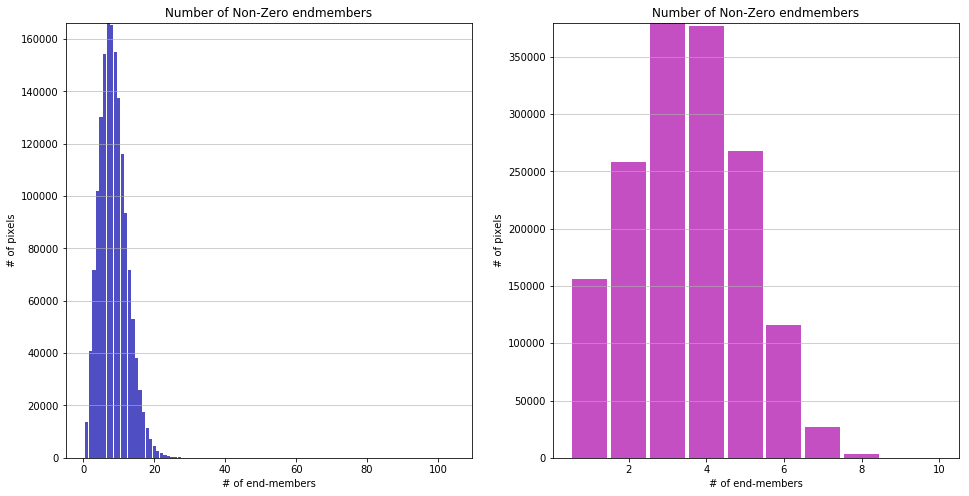

In [9]:
'Try to plot a histogram'
fig1 = plt.figure(figsize=(16,8))
plt.subplot(121)
n1, bins, patches = plt.hist(x=arr_countNonZero, bins=np.arange(0.5, (arr_countNonZero.max()+1.5),1), color='#0404aa',
                           alpha=0.7, histtype='bar', rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('# of pixels')
plt.xlabel('# of end-members')
plt.title('Number of Non-Zero endmembers')
maxfreq1 = n1.max()
'Set a clean upper y-axis limit'
plt.ylim(ymax=np.ceil(maxfreq1 / 10) *10 if maxfreq1 % 10 else maxfreq1 + 10)
plt.xlim(xmax=(arr_countNonZero.max()+0.5))

plt.subplot(122)
n1, bins, patches = plt.hist(x=arr_sigNonZero, bins=np.arange(0.5, (arr_sigNonZero.max()+1.5),1), color='#aa04aa',
                           alpha=0.7, histtype='bar', rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.ylabel('# of pixels')
plt.xlabel('# of end-members')
plt.title('Number of Non-Zero endmembers')
maxfreq1 = n1.max()
'Set a clean upper y-axis limit'
plt.ylim(ymax=np.ceil(maxfreq1 / 10) *10 if maxfreq1 % 10 else maxfreq1 + 10)
plt.xlim(xmax=(arr_sigNonZero.max()+0.5))

As a general rule it appears there are 8-10 endmembers chosen for each CRISM pixel but nomr that 2-6 have significant contributions, i.e. contributions of greater than 5% of the total weight by the coefficient. So for the mixtures I will consider that mixtures of 4-5 minerals. Another factor to consider is how many of the 4-5 dominant end-members are perhaps from the same class. Another point of interest is how often the MICA endmembers are used and if any of the MICA endmembers are used in other spectra of interest.

# End-member level statistics
In these statistics we can get a quick snap-shot of how often an end-member is used in the generation of the samples from the CRISM images which make up the MICA database. I will also be looking at how often the end-member is a significant contributor to a sample from the CRISM database. In addition, I will be looking at simple statistics like average co-efficient assigned to each endmemeber(when-ever non-zero) and average coefficient of the end-member when it is significant. I'm hoping this will give some basic count/idea on how imbalanced these datasets are.

In [10]:
'The number of times each endmember is used is'
arr_EMCount = np.count_nonzero(arrChosenPix, axis=0)
'The number of times the endmember is significant is'
arr_sigCount = np.count_nonzero(arr_sigEM, axis =0)

(0.0, 0.4)

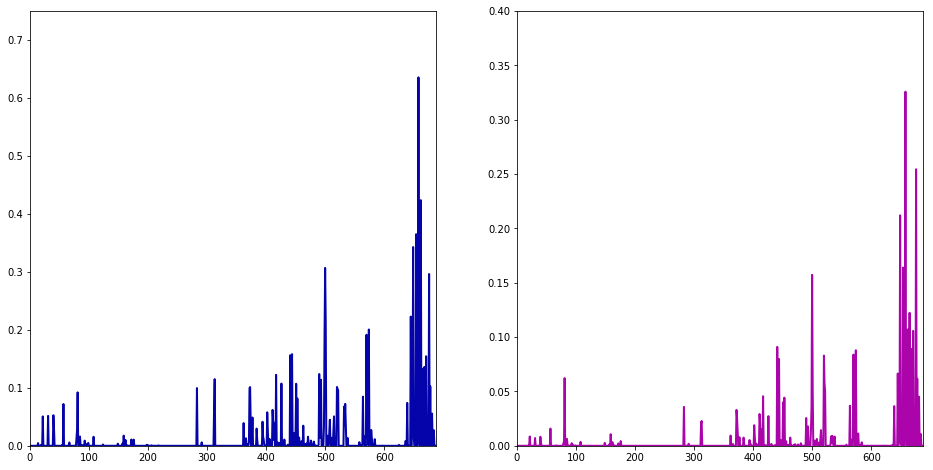

In [11]:
fig2 = plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(range(687), (np.asarray(arr_EMCount, dtype='f4')/arr_sigEM.shape[0]), linewidth=2.0, color='#0404aa' )
plt.xlim(xmin=0.5, xmax=687.5)
plt.ylim(ymin=0.0, ymax=0.75)
plt.subplot(122)
plt.plot(range(687), (np.asarray(arr_sigCount, dtype='f4')/arr_sigEM.shape[0]), linewidth=2.0, color='#aa04aa' )
plt.xlim(xmin=0.5, xmax=687.5)
plt.ylim(ymin=0.0, ymax=0.4)

The statistics show some interesting trends:
<ul> 
    <li> Most of the endmembers are either never used or used very very sparsely.
    <li> The most used endmemebers in the libarary are situated at the end of the library, these endmebers (#657-687) correspond to the MICA library endmembers. Thus, clearly the model seems to prefer CRISM type endmembers compared to earth based library end-members.In fact except for end-member no. 500 (Gypsum F1CC61B) none of the other non-MICA endmemebers is a significant contributor to more than 10% of the MICA image spectra. So in the next image I will blow up the MICA endmembers plot.
    <li> The nect step I will look at the mean/average values assigned to the cofficients for each of the end-members.
</ul>

In [12]:
'Mean and std when endmember is non-zero is'
arrChosenPix_emAvg = np.nanmean(np.where((arrChosenPix == 0), np.nan, arrChosenPix), axis=0)
arrChosenPix_emAvg[np.isnan(arrChosenPix_emAvg)] = 0
'Mean when endmember is non-zero and significant is'
arrChosenPix_sigEM = arrChosenPix * arr_sigEM
arrChosenPix_sigAvg = np.nanmean(np.where((arrChosenPix_sigEM == 0), np.nan, arrChosenPix_sigEM), axis=0)
arrChosenPix_sigAvg[np.isnan(arrChosenPix_sigAvg)] = 0

(0.0, 1.9319048)

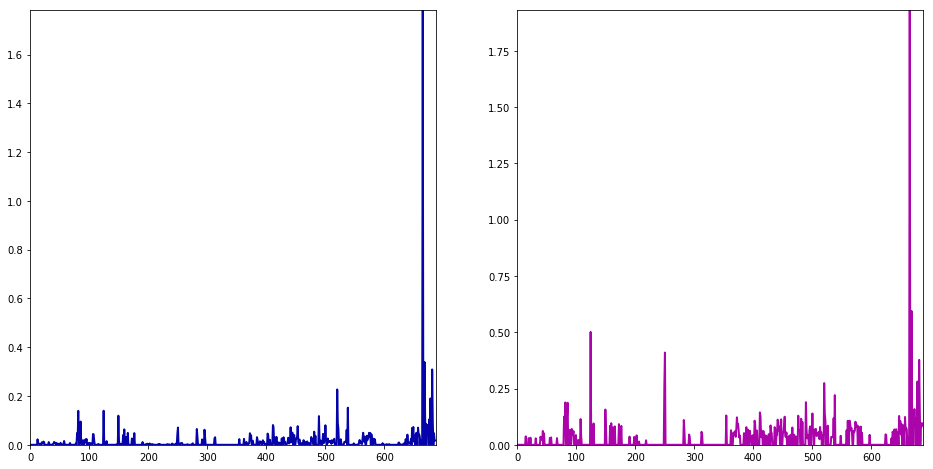

In [13]:
fig2 = plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(range(687), arrChosenPix_emAvg, linewidth=2.0, color='#0404aa' )
plt.xlim(xmin=-0.5, xmax=687.5)
plt.ylim(ymin=0.0, ymax=arrChosenPix_emAvg.max())
plt.subplot(122)
plt.plot(range(687), arrChosenPix_sigAvg, linewidth=2.0, color='#aa04aa' )
plt.xlim(xmin=-0.5, xmax=687.5)
plt.ylim(ymin=0.0, ymax=arrChosenPix_sigAvg.max())

Note that except for in specific cases the sum the weight of specific endmembers is not greater than or equal to 0.2.